# Part A Question 1


In [ ]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [ ]:
df = pd.read_csv('/content/full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [ ]:
df['label'] = df['filename'].str.split('_').str[-2]

In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [ ]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Q1a) Model training

In [ ]:
model_Q1 = Sequential(
    [Input(shape=(77,)), 
    Dense(128, activation='relu'), 
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2) ,
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') ])

opt = keras.optimizers.Adam(learning_rate=0.001)
callback = EarlyStopping(patience=3)

model_Q1.compile(optimizer=opt,
loss='binary_crossentropy',
metrics=['accuracy'])

history = model_Q1.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=256, 
                    verbose = 2, 
                    use_multiprocessing=True,
                    callbacks = callback,
                    validation_data=(X_test_scaled, y_test))

2022-09-17 07:15:49.463705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-17 07:15:49.463747: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 07:15:49.463764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-79949822-f0f0-47c9-a963-0ed5b351932d): /proc/driver/nvidia/version does not exist
2022-09-17 07:15:49.464005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/100
499/499 - 4s - loss: 0.6899 - accuracy: 0.5366 - val

# 1b) Plot train and test accuracy and loss against epochs

Early Stopping is used because the loss has already started to stabilise and stopped changing at around the 60th epoch, thus, there is no need to continue running any more epochs in case it overfits which will result in a worse model performance.

From the line plots below, we can see that the train accuracies is generally higher than the test accuracies and the loss is smaller for train data. This makes sense as the model was trained using training data and thus would perform better on the training data than the unseen test data.

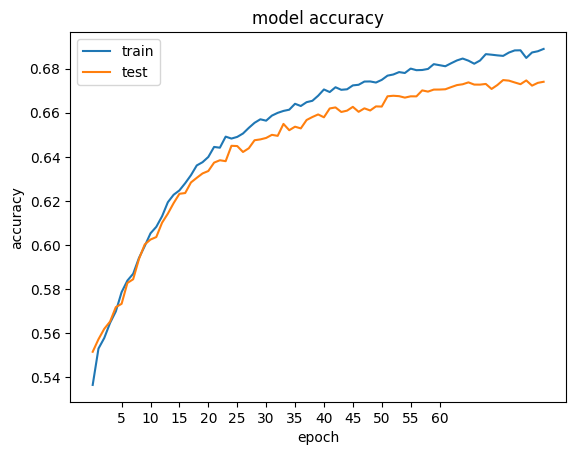

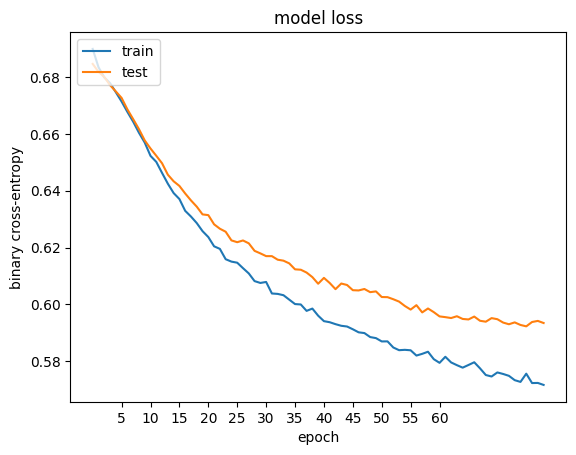

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35,40, 45, 50, 55, 60])
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('binary cross-entropy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35,40, 45, 50, 55, 60])
plt.legend(['train', 'test'], loc='upper left')

# Part A Question 2

In [ ]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.times = []
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time() - self.starttime)



# 2a) Plot mean cross-validation accuracies on the final epoch for different batch sizes 

In [ ]:
batch_sizes =  [128, 256, 512, 1024]

# run this function per batch size later on
def train(size):

    callback_2 = TimingCallback()
    kfold = KFold(n_splits=5, shuffle=True)
    
    
    accuracies=[]
    time_per_last_epoch = []
    es = EarlyStopping(patience=3)

    for train_index, test_index in kfold.split(X_train):
      
      X_train_scaled, X_test_scaled = preprocess_dataset(X_train[train_index], X_train[test_index])

      model = Sequential(
        [Input(shape=(77,)), 
        Dense(128, activation='relu'), 
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2) ,
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid') ])

      opt = keras.optimizers.Adam(learning_rate=0.001)

      model.compile(optimizer=opt,
      loss='binary_crossentropy',
      metrics=['accuracy'])


      history = model.fit(X_train_scaled, y_train[train_index],
                           batch_size=size,
                           epochs=100,
                           verbose=0,
                           callbacks=[callback_2 ,es],
                           validation_data=(X_test_scaled, y_train[test_index]))

        # only take last epoch's accuracy and loss per split
      accuracies.append(history.history['val_accuracy'][-1])
      time_per_last_epoch.append(callback_2.times[-1])


    # return mean of the accuracies and time taken
    return [
        np.mean(np.array(accuracies), axis=0),
        np.mean(np.array(time_per_last_epoch), axis=0)
    ]

In [ ]:
accuracies=[]
time_taken=[] 

for batch in batch_sizes:
    print("STARTING BATCH SIZE: "+str(batch)+"\n")
    accuracy, time_last_epoch = train(batch)
    accuracies.append(accuracy)
    time_taken.append(time_last_epoch)


STARTING BATCH SIZE: 128

STARTING BATCH SIZE: 256

STARTING BATCH SIZE: 512

STARTING BATCH SIZE: 1024



Text(0.5, 0, 'batch_sizes')

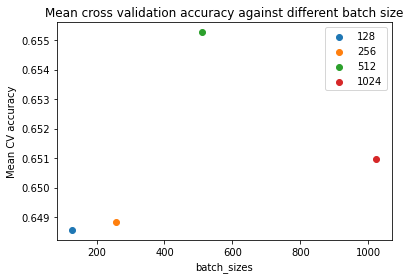

In [ ]:
plt.figure(2)
for i in range(len(batch_sizes)):
    plt.scatter(batch_sizes[i],accuracies[i])
plt.title('Mean cross validation accuracy against different batch size')
plt.legend(batch_sizes, loc='upper right')
plt.ylabel('Mean CV accuracy')
plt.xlabel('batch_sizes')

# 2b) Table of time taken to train last epoch and batch sizes

In [ ]:
table = pd.DataFrame(data={
    'batch_sizes': batch_sizes,
    'total_time': time_taken})

table

,batch_sizes,total_time
0,128,0.001860
1,256,0.003370
2,512,0.003178
3,1024,0.008259


# 2c) 

As we can see from the results above, a batch size of 512 seems to be the optimal for the problem above as it has the highest mean CV accuracy and only a slightly higher mean time of training the last epoch

# 2d) 

As batch size increases, the accuracy decreases while the time taken to train the network decreases. This is because with a larger batch size, the computation of the gradient descent step is faster since there are lesser batches, however, the loss function will not be minimised since there were lesser gradients to calculate. Hence there exists a trade-off between the time taken to train a network and the accuracy.

# 2e) Plot train and test accuracy using optimal batch size

In [ ]:
model_Q2 = Sequential(
        [Input(shape=(77,)), 
        Dense(128, activation='relu'), 
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2) ,
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid') ])

opt = keras.optimizers.Adam(learning_rate=0.001)
es = EarlyStopping(patience=3)

model_Q2.compile(optimizer=opt,
loss='binary_crossentropy',
metrics=['accuracy'])

history = model_Q2.fit(X_train_scaled, y_train,
                           batch_size=512,
                           epochs=100,
                           verbose=2,
                           callbacks=[es],
                           use_multiprocessing=True,
                           validation_data=(X_test_scaled, y_test))

Epoch 1/100
250/250 - 3s - loss: 0.6910 - accuracy: 0.5324 - val_loss: 0.6863 - val_accuracy: 0.5458 - 3s/epoch - 13ms/step
Epoch 2/100
250/250 - 3s - loss: 0.6844 - accuracy: 0.5502 - val_loss: 0.6825 - val_accuracy: 0.5564 - 3s/epoch - 11ms/step
Epoch 3/100
250/250 - 3s - loss: 0.6817 - accuracy: 0.5561 - val_loss: 0.6809 - val_accuracy: 0.5578 - 3s/epoch - 11ms/step
Epoch 4/100
250/250 - 3s - loss: 0.6792 - accuracy: 0.5630 - val_loss: 0.6780 - val_accuracy: 0.5620 - 3s/epoch - 12ms/step
Epoch 5/100
250/250 - 3s - loss: 0.6761 - accuracy: 0.5694 - val_loss: 0.6756 - val_accuracy: 0.5697 - 3s/epoch - 11ms/step
Epoch 6/100
250/250 - 3s - loss: 0.6733 - accuracy: 0.5738 - val_loss: 0.6733 - val_accuracy: 0.5730 - 3s/epoch - 12ms/step
Epoch 7/100
250/250 - 3s - loss: 0.6701 - accuracy: 0.5796 - val_loss: 0.6702 - val_accuracy: 0.5793 - 3s/epoch - 11ms/step
Epoch 8/100
250/250 - 3s - loss: 0.6675 - accuracy: 0.5859 - val_loss: 0.6674 - val_accuracy: 0.5847 - 3s/epoch - 13ms/step
Epoch 9/

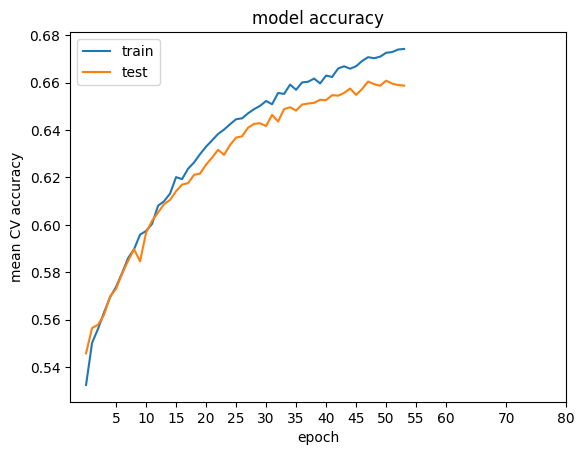

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('mean CV accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35,40, 45, 50, 55, 60, 70, 80])
plt.legend(['train', 'test'], loc='upper left')

# Question 3

# 3a) Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons

In [ ]:
# run this function per batch size later on
def train(size):

    es = EarlyStopping(patience=10)

    kfold = KFold(n_splits=5, shuffle=True)
    
    # used to store  loss and accuracy each fold
    accuracies=[]
    
    for train_index, test_index in kfold.split(X_train_scaled):

      X_train_scaled, X_test_scaled = preprocess_dataset(X_train[train_index], X_train[test_index])

      model = Sequential(
        [Input(shape=(77,)), 
        Dense(size, activation='relu'), 
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2) ,
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid') ])

      opt = keras.optimizers.Adam(learning_rate=0.001)

      model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

      history = model.fit(X_train_scaled, y_train[train_index],
                           batch_size=512,
                           epochs=100,
                           verbose=0,
                           callbacks=[es],
                           validation_data=(X_test_scaled, y_train[test_index]))

        # only take last epoch's accuracy and loss per split
        accuracies.append(history.history['val_accuracy'][-1])

    # return mean of the accuracies and loss and time taken
    return [
        np.mean(np.array(accuracies), axis=0),
    ]

In [ ]:
neuron_sizes = [64, 128, 256]
accuracies=[]

for size in neuron_sizes:
    print("STARTING NEURON SIZE: "+str(size)+"\n")
    accuracy = train(size)
    accuracies.append(accuracy)

STARTING NEURON SIZE: 64

STARTING NEURON SIZE: 128

STARTING NEURON SIZE: 256



Text(0.5, 0, 'neuron number')

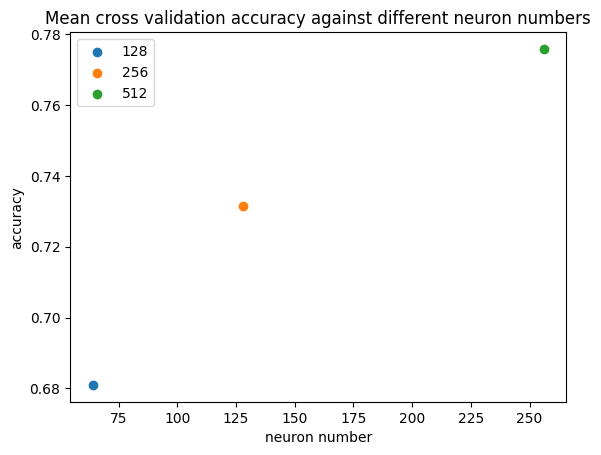

In [ ]:
plt.figure(2)
for i in range(len(neuron_sizes)):
    plt.scatter(neuron_sizes[i],accuracies[i])
plt.title('Mean cross validation accuracy against different neuron numbers')
plt.legend(batch_sizes, loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('neuron number')

# 3b)

The optimal number of neurons is 256 as it has the highest mean cv accuracy

# 3c) Plot the train and test accuracies against training epochs with the optimal number of neurons 

In [ ]:
model_Q3 = Sequential(
        [Input(shape=(77,)), 
        Dense(256, activation='relu'), 
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2) ,
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid') ])

opt = keras.optimizers.Adam(learning_rate=0.001)
es = EarlyStopping(patience=3)
model_Q3.compile(optimizer=opt,
loss='binary_crossentropy',
metrics=['accuracy'])

history = model_Q3.fit(X_train_scaled, y_train,
                           batch_size=512,
                           epochs=100,
                           verbose=0,
                           callbacks = [es],
                           use_multiprocessing=True,
                           validation_data=(X_test_scaled, y_test))

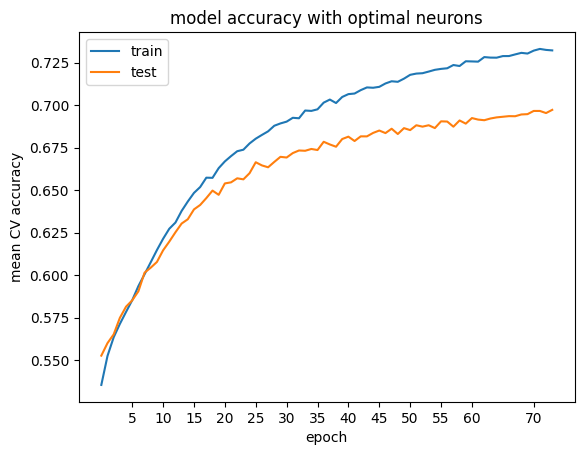

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with optimal neurons')
plt.ylabel('mean CV accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35,40, 45, 50, 55, 60, 70])
plt.legend(['train', 'test'], loc='upper left')

# 3d)

Dropouts are used to randomly drop neurons (along with their connections) from the networks during training. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better and thereby reduces overfitting.

# 3e)

Another solution to reduce overfitting is regularization of weights. A penalty term (regularization term) is added to the cost function to avoid the weights from gaining too large values that worsens the model's ability to generalise  

In [ ]:
model_Q3e = Sequential([ Input(shape=(77,)),
        Dense(256, activation='relu',kernel_regularizer=l2(0.0001)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.2) ,
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.2),
        Dense(1, activation='sigmoid') ])

opt = keras.optimizers.Adam(learning_rate=0.001)

es = EarlyStopping(patience=3)

model_Q3e.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

history = model_Q3e.fit(X_train_scaled, y_train,
                           batch_size=512,
                           epochs=100,
                           verbose=0,
                           callbacks = [es],
                           use_multiprocessing=True,
                           validation_data=(X_test_scaled, y_test))

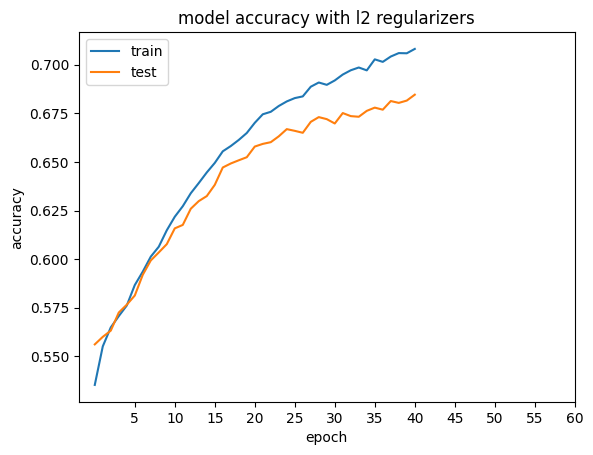

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with l2 regularizers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35,40, 45, 50, 55, 60])
plt.legend(['train', 'test'], loc='upper left')

# Q4a)

'new_record.csv' is the preprocessed wave record in csv format (after using the data_preprocess.ipynb).
This original recording is labelled as positive. 

In [ ]:
df_new = pd.read_csv('/content/new_record.csv')
df_new = df_new.drop(['filename'], axis=1)
df_new

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,143.554688,1422,109.384615,0.650132,0.07235,0.553843,0.078469,0.264569,0.013336,0.005018,...,0.588109,102.368439,-1.598961,78.464859,2.811341,87.120514,-3.631689,91.342911,0.104429,89.58107


Preprocess and scale the new csv file using the same functions above in Q1

In [ ]:
X_train_scaled, df_new_scaled = preprocess_dataset(X_train, df_new)

# Q4b)

Using the optimized model from Q3c) with batch size of 512 and hidden neurons being 256, we pass the new record in to predict the label of the new recording

In [ ]:
test_label = model_Q3.predict(df_new_scaled)

Now we use this model to make a prediction on this new test record, with a threshold of 0.5. If test_label => 0.5, it is a positive label, else it is a negative label

In [ ]:
if test_label[0] < 0.50:
    print("This is predicted as negative label!")
else:
    print("This is predicted as positive label!")

This is predicted as negative label!


# 4c)

From the force plot of feature importance below, we can infer that 'spec_bw_mean' has the greatest impact on increasing the probability that the label is positive. This is because it has the greatest proportion (0.4562) of increasing the base probability of a prediction at 0.49.

In [ ]:
!pip install shap

In [ ]:
import tempfile
import shap
from IPython.core.display import display, HTML

explainer = shap.DeepExplainer(model_Q3, X_train_scaled)
shap_values = explainer.shap_values(df_new_scaled)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = df_new.columns)

# Summary

Limitations of current approach
In our current approach, we need to first extract the features from the audio clips, adding an extra step to our machine learning pipeline. Therefore, the quality of our model depends on the quality of feature extraction. We see that in our optimized model, there are still some signs of overfitting which should be addressed. In addition,  the number of data points (training examples) are low, and our model will perform better if we have more data.

Most Impactful Optimization
Finding the optimal batch size made our model better, however, increase the number of hidden neurons had the most impact on our model performance. As the number of neurons increased, the model was able to learn more complex feature representations of the input data. The functions learnt closely resemble the complexity of the data and the model is able to generalize well on unseen real world data.

Alternatives for handling waveform data
Audio clips are waveform data which are also sequential data. There another type of Neural Networks called as Recurrent Neural Networks (RNNs), which are mroe suited in modelling sequential data. Similar to recurrent neural networks (RNNs), transformers are another type of networks designed to handle sequential input data. These options may be more suitable for audio datasets.